In [1]:
%pip install datasets transformers torch scikit-learn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [6]:
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_scheduler,
    DataCollatorWithPadding
)
from datasets import load_dataset
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, classification_report

In [3]:
%pip install -U datasets fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [1]:
# 50k labeled dataset
# 25k train; 25k test

from datasets import load_dataset

raw_datasets = load_dataset("stanfordnlp/imdb")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [2]:
print(raw_datasets)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [7]:
# Load pre-trained tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding=False,
        max_length=256
    )

In [9]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [10]:
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

In [11]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [12]:
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    batch_size=8,
    collate_fn=data_collator
)

eval_dataloader = DataLoader(
    tokenized_datasets["test"],
    batch_size=8,
    collate_fn=data_collator
)


In [13]:
# Load pre-trained BERT for sequence classification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [15]:
print(device)

cuda


In [16]:
num_epochs = 2
num_training_steps = num_epochs * len(train_dataloader)

In [17]:
# Optimizer & LR scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps = int(0.1 * num_training_steps),
    num_training_steps=num_training_steps
)

In [ ]:
# Train the model
progress_bar = tqdm(range(num_training_steps), desc="Training")

model.train()

for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch) # run forward pass and cross-entropy loss calculation.
        loss = outputs.loss # extracts the computed loss from the model’s output.
        loss.backward() # run backpropagation step;
        # compute gradients of the loss with respect to all model parameters.

        optimizer.step() # applies the gradient updates
        lr_scheduler.step()
        optimizer.zero_grad() # clears the gradients on all model parameters.

        progress_bar.set_postfix({"loss": loss.item()})
        progress_bar.update(1)

Training:   0%|          | 0/6250 [00:00<?, ?it/s]

100%|██████████| 6250/6250 [39:10<00:00,  2.66it/s]

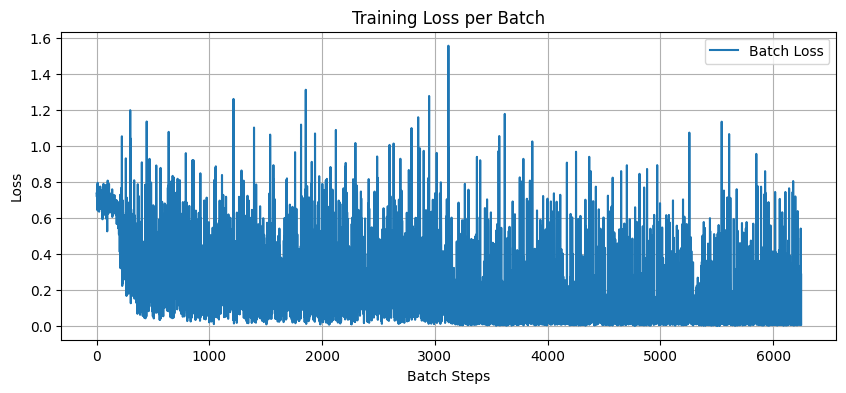

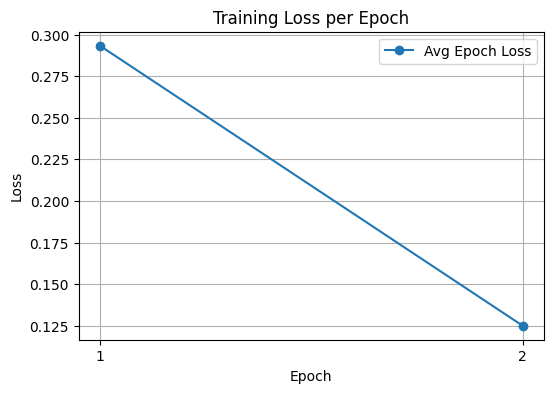

In [18]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Store losses
batch_losses = []
epoch_losses = []

# progress_bar = tqdm(range(num_training_steps), desc="Training")
progress_bar = tqdm(range(num_training_steps))

model.train()

for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = 0

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        # Track loss
        batch_losses.append(loss.item())
        epoch_loss += loss.item()
        num_batches += 1

        # progress_bar.set_postfix({"loss": loss.item()})
        progress_bar.update(1)

    avg_epoch_loss = epoch_loss / num_batches
    epoch_losses.append(avg_epoch_loss)
    # print(f"Epoch {epoch+1} Average Loss: {avg_epoch_loss:.4f}")

# progress_bar.close()

# ---- Plot per batch loss ----
plt.figure(figsize=(10, 4))
plt.plot(batch_losses, label="Batch Loss")
plt.xlabel("Batch Steps")
plt.ylabel("Loss")
plt.title("Training Loss per Batch")
plt.legend()
plt.grid(True)
plt.show()

# ---- Plot epoch average loss ----
plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', label="Avg Epoch Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
## Advance training loop

# from torch.nn.utils import clip_grad_norm_
# from torch.cuda.amp import autocast, GradScaler

# optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
# scaler = GradScaler()

# model.train()

# for epoch in range(num_epochs):
#     for batch in train_dataloader:
#         batch = {k: v.to(device) for k, v in batch.items()}

#         optimizer.zero_grad()

#         with autocast():
#             outputs = model(**batch)
#             loss = outputs.loss

#         scaler.scale(loss).backward()

#         # Gradient clipping
#         clip_grad_norm_(model.parameters(), max_norm=1.0)

#         scaler.step(optimizer)
#         scaler.update()
#         lr_scheduler.step()


In [19]:
# Save model and tokenizer
model.save_pretrained("./saved_model")
tokenizer.save_pretrained("./saved_model")

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json')

In [20]:
# Evaluate the model
predictions = []
true_labels = []

model.eval()

for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        # Forward pass
        outputs = model(**batch) # Feeds `input_ids` and `attention_mask` into the model.

    logits = outputs.logits # Gets the raw output scores from the model.
    preds = torch.argmax(logits, dim=-1) # Converts raw scores into predicted class label.
    predictions.extend(preds.cpu().numpy())
    true_labels.extend(batch["labels"].cpu().numpy())

print("Test Accuracy:", accuracy_score(true_labels, predictions))
print(classification_report(true_labels, predictions))

Test Accuracy: 0.9248
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     12500
           1       0.92      0.93      0.93     12500

    accuracy                           0.92     25000
   macro avg       0.92      0.92      0.92     25000
weighted avg       0.92      0.92      0.92     25000



Test Accuracy: 0.9248
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     12500
           1       0.92      0.93      0.93     12500

    accuracy                           0.92     25000
   macro avg       0.92      0.92      0.92     25000
weighted avg       0.92      0.92      0.92     25000

ROC-AUC: 0.9778444032
PR AUC: 0.9770583148633929
Matthews Correlation Coefficient: 0.8496210545503061
Cohen's Kappa: 0.8496


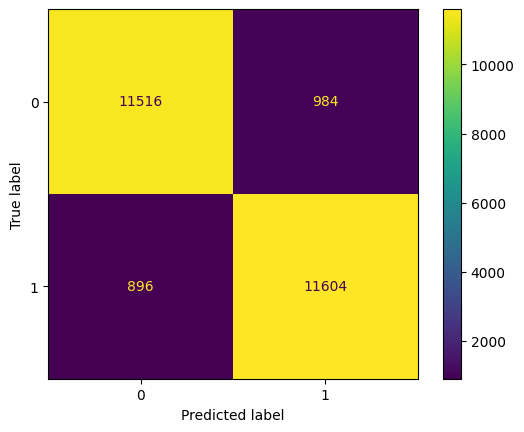

In [21]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    average_precision_score,
    matthews_corrcoef,
    cohen_kappa_score
)

import torch

predictions = []
true_labels = []
probs = []

model.eval()

for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    preds = torch.argmax(logits, dim=-1)

    predictions.extend(preds.cpu().numpy())
    true_labels.extend(batch["labels"].cpu().numpy())

    softmax_probs = torch.softmax(logits, dim=-1)
    probs.extend(softmax_probs.cpu().numpy())

print("Test Accuracy:", accuracy_score(true_labels, predictions))
print(classification_report(true_labels, predictions))

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


# If binary
if probs[0].shape[0] == 2:
    positive_probs = [p[1] for p in probs]
    print("ROC-AUC:", roc_auc_score(true_labels, positive_probs))
    print("PR AUC:", average_precision_score(true_labels, positive_probs))

# MCC and Cohen’s Kappa
print("Matthews Correlation Coefficient:", matthews_corrcoef(true_labels, predictions))
print("Cohen's Kappa:", cohen_kappa_score(true_labels, predictions))


ROC-AUC: 0.9778


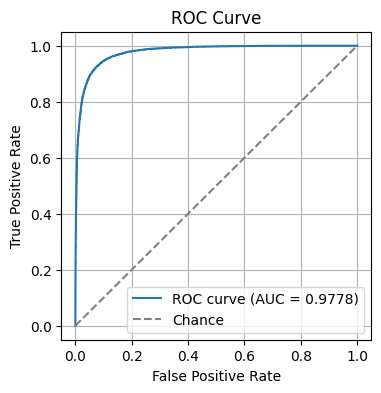

PR AUC (Average Precision): 0.9771


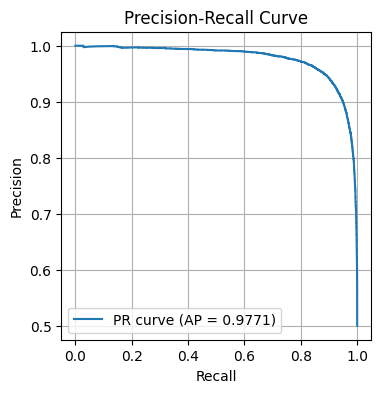

In [22]:
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve
)
import matplotlib.pyplot as plt

# If binary classification
if probs[0].shape[0] == 2:
    # Extract probability for class 1 (positive class)
    positive_probs = [p[1] for p in probs]

    # ---- ROC-AUC ----
    roc_auc = roc_auc_score(true_labels, positive_probs)
    print(f"ROC-AUC: {roc_auc:.4f}")

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(true_labels, positive_probs)

    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ---- Precision-Recall AUC ----
    pr_auc = average_precision_score(true_labels, positive_probs)
    print(f"PR AUC (Average Precision): {pr_auc:.4f}")

    precision, recall, pr_thresholds = precision_recall_curve(true_labels, positive_probs)

    plt.figure(figsize=(4, 4))
    plt.plot(recall, precision, label=f"PR curve (AP = {pr_auc:.4f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


In [23]:
# Load back the model + tokenizer
model_path = "./saved_model"

inference_tokenizer = BertTokenizer.from_pretrained(model_path)
inference_model = BertForSequenceClassification.from_pretrained(model_path)
inference_model.to(device)
inference_model.eval()

# Example text to predict
text = "This movie was boring, I hated it!"

inputs = inference_tokenizer(
    text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=256
)
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = inference_model(**inputs)

logits = outputs.logits
predicted_class_id = torch.argmax(logits, dim=-1).item()

print(f"Predicted class ID: {predicted_class_id} ({'Positive' if predicted_class_id == 1 else 'Negative'})")


Predicted class ID: 0 (Negative)


In [25]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset
from torch.nn.functional import softmax

# Load back the model + tokenizer
model_path = "./saved_model"  # Replace with your actual saved path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inference_tokenizer = BertTokenizer.from_pretrained(model_path)
inference_model = BertForSequenceClassification.from_pretrained(model_path)
inference_model.to(device)
inference_model.eval()

# Load IMDB dataset - test split
test_dataset = raw_datasets["test"]

# Select first N examples
N = 5
sample_texts = test_dataset["text"][:N]
true_labels = test_dataset["label"][:N]

print("\nSelected examples for inference:")
for i, text in enumerate(sample_texts):
    print(f"\nExample {i+1} [True: {'Positive' if true_labels[i] else 'Negative'}]:")
    print(text[:200].replace("\n", " ") + " ...")

# Batch tokenize
inputs = inference_tokenizer(
    sample_texts,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=256
)

inputs = {k: v.to(device) for k, v in inputs.items()}

# Run inference
with torch.no_grad():
    outputs = inference_model(**inputs)

logits = outputs.logits
probs = softmax(logits, dim=-1)
predicted_class_ids = torch.argmax(probs, dim=-1).cpu().numpy()

print("\nPredictions:")
for i, pred in enumerate(predicted_class_ids):
    pred_label = "Positive" if pred == 1 else "Negative"
    true_label = "Positive" if true_labels[i] == 1 else "Negative"
    confidence = probs[i][pred].item()
    print(f"Example {i+1}: Predicted: {pred_label} ({confidence:.4f}) | True: {true_label}")



Selected examples for inference:

Example 1 [True: Negative]:
I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Bab ...

Example 2 [True: Negative]:
Worth the entertainment value of a rental, especially if you like action movies. This one features the usual car chases, fights with the great Van Damme kick style, shooting battles with the 40 shell  ...

Example 3 [True: Negative]:
its a totally average film with a few semi-alright action sequences that make the plot seem a little better and remind the viewer of the classic van dam films. parts of the plot don't make sense and s ...

Example 4 [True: Negative]:
STAR RATING: ***** Saturday Night **** Friday Night *** Friday Morning ** Sunday Night * Monday Morning <br /><br />Former New Orleans homicide cop Jack Robideaux (Jean Claude Van Damme) is re-assigne ...

Example 5 [True: Negative]:
F